In [1]:
import os
import pandas as pd
import prody
import py3Dmol
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from metfish.utils import get_Pr


In [2]:
apo_holo_dir = "/global/cfs/cdirs/m3513/metfish/apo_holo_data"
test_data_df = pd.read_csv(f"{apo_holo_dir}/input_no_training_data.csv")
names = test_data_df['name'].to_list()

In [3]:
name = names[15]
fname = f"{apo_holo_dir}/pdbs/{name}_atom_only.pdb"
n_modes = 1
n_confs = 10
rmsd = 1

# select alpha carbons
structure = prody.parsePDB(fname)
calphas = structure.select('calpha')
numResidues = structure.numResidues()

# perform normal mode analysis
anm = prody.ANM('ANM analysis')
anm.buildHessian(calphas)  # default values are cutoff=15.0 and gamma=1.0
anm.calcModes(n_modes=n_modes)

# write nmd file"
os.makedirs(f'{name}_nma', exist_ok=True)
prody.writeNMD(f'{name}_nma/{name}_nres{numResidues}.nmd', anm, calphas)

@> 4025 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> Hessian was built in 0.16s.
@> 1 mode was calculated in 0.24s.


'1Y3N_A_nma/1Y3N_A_nres490.nmd'

In [4]:
# view modes
# VMD.setPath()
# viewNMDinVMD('structure_anm_modes.nmd')

In [5]:
# extend the model
anm_ext, _ = prody.extendModel(anm, calphas, structure, norm=True)

# sample conformations along the ANM nodes
#ens = sampleModes(anm_ext, atoms=structure, n_confs=n_confs, rmsd=2)
ens = prody.traverseMode(anm_ext[0], atoms=structure, n_steps=n_confs/2, rmsd=rmsd)

# write DCD file 
os.makedirs(f'{name}_nma/{name}_rmsd{rmsd}/', exist_ok=True)
fn = os.path.join(f'{name}_nma/{name}_rmsd{rmsd}', f'{name}_rmsd{rmsd}.dcd')
prody.writeDCD(fn, ens)

@> Parameter: rmsd = 1.00 A
@> Parameter: n_steps = 5
@> Step size is 0.20 A RMSD
@> Mode is scaled by 8.222197713203123.
@> DCD file was written in 0.01 seconds.
@> 0.51 MB written at input rate 39.01 MB/s.
@> 11 coordinate sets written at output rate 845 frame/s.


'1Y3N_A_nma/1Y3N_A_rmsd1/1Y3N_A_rmsd1.dcd'

In [6]:
# write confirmations
structure.addCoordset(ens.getCoordsets())
structure.all.setBetas(0)
structure.ca.setBetas(1)

for i in range(1, structure.numCoordsets()):  # skipping 0th coordinate set
    fn = os.path.join(f'{name}_nma/{name}_rmsd{rmsd}', f'{name}_rmsd{rmsd}_conf{i}.pdb')
    prody.writePDB(fn, structure, csets=i)

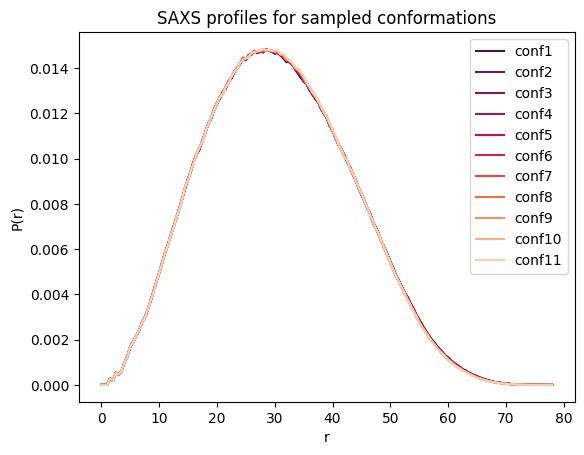

In [7]:
# calculate and plot saxs curves
palette = [mcolors.to_hex(c) for c in sns.color_palette('rocket', n_colors=n_confs+2)]

fig, ax = plt.subplots(1, 1)
for i in range(1, n_confs + 2):
    fn = os.path.join(f'{name}_nma/{name}_rmsd{rmsd}', f'{name}_rmsd{rmsd}_conf{i}.pdb')
    r, p = get_Pr(fn, name, None, 0.5)
    
    ax.plot(r, p, color=palette[i], label=f'conf{i}')
    ax.set(xlabel='r', ylabel='P(r)', title='SAXS profiles for sampled conformations')

ax.legend()
plt.savefig(f'{name}_nma/{name}_rmsd{rmsd}/{name}_rmsd{rmsd}_saxs.png')

In [8]:
# visualize conformations
view = py3Dmol.view(width='300', viewergrid=(1, 2))
# compare different models
for i in range(1, n_confs):
    fn = os.path.join(f'{name}_nma/{name}_rmsd{rmsd}', f'{name}_rmsd{rmsd}_conf{i}.pdb')
    view.addModel(open(fn, 'r').read(), 'pdb', viewer=(0, 0))
    view.setStyle({'model': i-1}, {"cartoon": {'color': palette[i]}}, viewer=(0, 0))

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol